#  Preprocessor code for the tFUS - mVEP BCI paradigm

### Written by Joshua Kosnoff except where otherwise noted. MNE Python / Autoreject code was copied liberally from their respective tutorials


The mVEP BCI classifier is based on 12 stimuli per scan epoch - one for each row and column index. Before conducting any neural analysis, we need to extract the stimuli labels that correspond to the on-target stimuli for each trial/subject, and convert the raw data format into trial epochs. 

While we're at it, we can also preprocess the EEG data with standard techniques. These include bandpass filtering from 1 - 40 Hz, downsampling to 100 Hz, and applying Common Average Referencing. We will also run automatic ICA eyeblink removal using channels Fp1 and Fp2 as proxies for EoG channels, and the autoreject channel to remove bad trials / interpolate bad sensors.

## Preprocessing and Data Extraction

In [1]:
###################################################
# CHANGE THESE PATHS - the relative paths for box should be the same. You may need to change
# the relative FreeSurfer paths if you have different nomenclature or organization methods

path_to_file_paths = r"file_paths_remapped.json"
path_to_box = r"/Users/jkosnoff/Library/CloudStorage/Box-Box/Joshua-Speller-Paper/Data/EEG_Data/EEG_Data/"

path_to_freesurfer = path_to_box + r'/Freesurfer'
path_to_freesurfer = r"/Users/jkosnoff/Docs/Freesurfer"

parse_mode = 'per_scan'

output_file_name = 'Analysis_Rerun.pkl'
###################################################

In [2]:
####################################################################
## DO NOT MODIFY THE NEXT CELLS UNLESS YOU KNOW WHAT YOU'RE DOING ##
####################################################################

# Native Python Packages
import json

# Third Party Packages
import autoreject
import mne
from mne.preprocessing import ICA
import numpy as np
import pandas as pd

# Silence mne logs
mne.set_log_level('CRITICAL')

# MNE Toolbox functions for mVEP BCI analysis
def preprocess_mne(mne_raw, filter_win = [1, 40], downsample_freq=100.0, CAR = True):
    """
    A function to preprocess mne data. The function will bandpass filter data, resample the data, and
    apply common average referencing if the argument is passed.
    
    Inputs:
        mne_raw: an MNE data structure. It could be Raw or Epoch
        filter_win: the list of boundaries to bandpass filter the data. Default is 1 - 40Hz, 
                    which is field standard for EEG
        downsample_freq: the frequency to resample the data to. Default is 100 Hz, which is still
                    more than x2 the maximum filter frequency (see Nyquist Theorem)
        CAR: a boolean value for whether or not to apply Common Average Referencing.
    
    Outputs:
        the preprocessed MNE data
    
    """
    
    # Band-pass filter
    mne_raw.filter(filter_win[0], filter_win[1], fir_design='firwin', picks=None);

    # Downsample
    mne_raw.resample(downsample_freq);

    if CAR:
        # Common Average Reference
        mne_raw.set_eeg_reference('average', projection=False); # projection = False to apply reference to base data
        
    return mne_raw
    
def mVEP_training_to_epoch(mne_raw, mne_events, window = [-0.2, 0.5], normalize = True, ICA_removal = True, 
                          target_string = "AHOV2_", threshold = 2.0):
    """
    Produce a dictionary of {hits: mne_epoch, non-hits: mne_epoch} based on the training data schema 
    AHOV2_.
    
    Note: This will NOT produce correct results for testing sessions, as currently the order of hits/non-hits is 
    hardcoded based on AHOV2_.
    
    Inputs: 
        mne_raw: an mne.Raw file type containing the data
        mne_events: an array of event times
        window: the window to extract for each epoch, in seconds
        normalize: whether to z-score each channel
        ICA_removal: whether to apply automatic ICA removal to the data
        target_string: the string to match the EEG data events to
        threshold: z-threshold for ICA outliers
        
    Output:
        A dictionary containing the epochs for "hits" and "non-hits"
    
    """
    
    keyboard = np.array([["A", "B", "C", "D", "E", "F"], 
                         ["G", "H", "I", "J", "K", "L"], 
                         ["M", "N", "O", "P", "Q", "R"], 
                         ["S", "T", "U", "V", "W", "X"],
                         ["Y", "Z", "0", "1", "2", "3"],
                         ["4", "5", "6", "7", "8", "_"]
                        ])
    
    S1s = np.where(mne_events[:,-1] == 1)[0]
    S2s = np.where(mne_events[:,-1] == 2)[0]
    S3s = np.where(mne_events[:,-1] == 3)[0]
    S4s = np.where(mne_events[:,-1] == 4)[0]
    S5s = np.where(mne_events[:,-1] == 5)[0]
    S6s = np.where(mne_events[:,-1] == 6)[0]
    S7s = np.where(mne_events[:,-1] == 7)[0]
    S8s = np.where(mne_events[:,-1] == 8)[0]
    S9s = np.where(mne_events[:,-1] == 9)[0]
    S10s = np.where(mne_events[:,-1] == 10)[0]
    S11s = np.where(mne_events[:,-1] == 11)[0]
    S12s = np.where(mne_events[:,-1] == 12)[0]
    Ss = [S1s, S2s, S3s, S4s, S5s, S6s, S7s, S8s, S9s, S10s, S11s, S12s]
    
    n_repeats = int(len(S1s) / len(target_string))
    print("Calculated", n_repeats, " repeats")

    
    # Now, I realize that try and except statements are generally frowned upon
    # I also realize that blankedly deleting variables inside a function may
    # lead to unintended consequences. 
    # However, I also know from running and creating this code that not deleting
    # these variables ahead of time led to bugs... so, yeah, let's try to delete
    # these problems causers.
    try:
        del all_hits
        del all_nonhits
    except NameError:
        pass
    
    if ICA_removal:
        # Use MNE python's automatic EOG artifact detection. Since we don't have an EOG channel, 
        # assign a frontal electrode to be the EOG channel (FP1). 
        ica = ICA(n_components=.99, max_iter='auto', random_state=97)
            
        ica.fit(mne_raw)

        ica.exclude = []
        
        # Because we used a couple of different caps for throughout the data collection process, 
        # there are some electrodes with inconsistent capitalizaions. We catch those with our
        # if statement
        if "FP1" in mne_raw.ch_names:
            eog_indices, eog_scores = ica.find_bads_eog(mne_raw, ch_name = ["FP1"], threshold = threshold)
        elif "Fp1" in mne_raw.ch_names:
            eog_indices, eog_scores = ica.find_bads_eog(mne_raw, ch_name = ["Fp1"], threshold = threshold)
        else:
            print("No Fp1 channel found, using: ",mne_raw.ch_names[0])
            eog_indices, eog_scores = ica.find_bads_eog(mne_raw, ch_name = all_hits.ch_names[0], threshold = threshold)
        print(f"Found and removing {len(eog_indices)} eye-blink ICA components")
        ica.exclude = eog_indices
        ica.apply(mne_raw)
    
    for i, l in enumerate(target_string):
        shifted_idx = i * n_repeats
        event_num = []
        for k in range(2): # 0 or 1 (There are two "hits" per epoch - the row and the column)
            val = int(np.where(keyboard == l)[k][0]) + k*6
            event_num.append(val) 

        event_num = np.array(event_num, dtype = int)
        event_idx = np.array([i*n_repeats + j for j in range(n_repeats)], dtype = int)    
        non_hits_event_nums = np.array(list(set(range(0,12)) - set(event_num)), dtype=int)

        hit_idx = np.array(Ss)[event_num][:, event_idx].flatten()
        nonhit_idx = np.array(Ss)[non_hits_event_nums][:, event_idx].flatten()

        event_hits = mne_events[hit_idx]
        event_nonhits = mne_events[nonhit_idx]

        curr_hits = mne.Epochs(mne_raw.copy(), event_hits, tmin=window[0], tmax=window[1])
        curr_nonhits = mne.Epochs(mne_raw.copy(), event_nonhits, tmin=window[0], tmax=window[1])

        if normalize:
            curr_hits._data = mne.decoding.Scaler(info=curr_hits.info, scalings='mean').fit_transform(curr_hits.copy().get_data())
            curr_nonhits._data = mne.decoding.Scaler(info=curr_nonhits.info, scalings='mean').fit_transform(curr_nonhits.copy().get_data())

        if 'all_hits' in locals():
            all_hits = mne.concatenate_epochs([all_hits, curr_hits], add_offset=False)
            all_nonhits = mne.concatenate_epochs([all_nonhits, curr_nonhits], add_offset=False)

        else:
            all_hits = curr_hits
            all_nonhits = curr_nonhits
            
    return {"hits": all_hits, "non-hits": all_nonhits}
    
def epoch_data(vhdr_file, path_to_RAS, preprocess=True, normalize=True, target_string = "AHOV2_", ICA_removal = True):
    
    # Initialize the data recordings
    mne_raw = mne.io.read_raw_brainvision(vhdr_file,misc=['ECG', 'EMG', 'FootPad'], preload=True)
    mont = mne.channels.read_dig_localite(path_to_RAS)
    mne_raw.set_montage(mont, match_case=False)
    
    # Preprocess the data
    if preprocess:
        mne_raw = preprocess_mne(mne_raw)
    
    # Extract the events from the vhdr file
    raw_event_id = {
            'Stimulus/S{:3d}'.format(i): i for i in range(1, 13)}

    mne_events, ev_id = mne.events_from_annotations(
        raw=mne_raw, event_id=raw_event_id)
    
    epoch_dict = mVEP_training_to_epoch(mne_raw=mne_raw, mne_events=mne_events, 
                                        normalize=normalize, 
                                        target_string=target_string, ICA_removal = ICA_removal)
    return epoch_dict

In [3]:
assert parse_mode in ["per_scan", "per_letter", "per_subject"], f"parse_mode should be 'per_scan', 'per_letter', or 'per_subject', got: '{parse_mode}'"

# Initialize Data Frame
df = pd.DataFrame(columns=["subject", "condition", "hit", "data_epoch"])

def idx_per_scan(i, scans_per_letter, total_scans):
    return i

def idx_per_letter(i, scans_per_letter, total_scans):
    return np.linspace(i*scans_per_letter, (i+1)*scans_per_letter-1, scans_per_letter, dtype=int)

def idx_per_subject(i, scans_per_letter, total_scans):
    return np.linspace(0, total_scans, total_scans, dtype= int)

try: # clear local variables if they exist to free up memory
    del all_hits
    del all_nonhits
except:
    pass

# Load subject data
with open(path_to_file_paths) as f:
    file_paths = json.load(f)
    
# Loop through all the subjects data
for subject in list(file_paths.keys()):
    
    # Get paths from the json file
    subject_dir = path_to_freesurfer + file_paths[subject]["subject_dir"]
    RAS_file = subject_dir + file_paths[subject]["RAS"]
    vhdr_files = file_paths[subject]["vhdr_paths_training"]
    session_num = RAS_file.split(r"/")[-2]

    # For Subj06, we used both diagonals. For all others, we just used the one diagonal
    if subject == "Subj06":
        target_string = "AHOV2_FKPUZ4"
    else:
        target_string = "AHOV2_"

    for condition in list(vhdr_files.keys()):
        
        # If we have multiple trials of one condition for a subject, only include one of them
        if condition[-1] not in ["2", "3", "4", "5", "6", "7", "8", "9"]:        
            vhdr_file = path_to_box + subject + r"/" + vhdr_files[condition]

            # Step 1: Reshape the data into epochs of "hits" and "non-hits"
            epoch_dict = epoch_data(vhdr_file = vhdr_file, 
                                    path_to_RAS=RAS_file, 
                                    normalize=True, 
                                    target_string = target_string)

            # Step 2: Get session specific repeat numbers
            n_scans = len(epoch_dict["hits"].events)
            scans_per_letter = int(n_scans / len(target_string))    

            if parse_mode == 'per_scan':
                parse_num_hits = len(epoch_dict["hits"].events)
                parse_num_nonhits = len(epoch_dict["non-hits"].events)
                idx_func = idx_per_scan

            elif parse_mode == 'per_letter':
                parse_num_hits = int(len(target_string))
                parse_num_nonhits = int(len(target_string))
                idx_func = idx_per_letter

            else:
                parse_num_hits = 1
                parse_num_nonhits = 1
                idx_func = idx_per_subject

            # Step 3: Extract the FS region for each of the hits 
            # idx = the epoch indices to include in the extraction. 
            for i in range(parse_num_hits):
                idx = idx_func(i, scans_per_letter=scans_per_letter, total_scans = n_scans)
                ep = epoch_dict["hits"][idx].average() # .__getitem__(idx).average()

                dat = ep.get_data()
                ep = mne.EpochsArray(data = dat.reshape(1, dat.shape[0], dat.shape[1]), 
                                     info = ep.info, events=None, tmin=-0.2)

                df.loc[len(df)] = {"subject": subject, "condition": condition, "hit": True, "data_epoch": ep} 

Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 10  repeats
Found and removing 1 eye-blink ICA components
Calculated 10  repeats
Found and removing 1 eye-blink ICA components
Calculated 10  repeats
Found and removing 2 eye-blink ICA components
Calculated 10  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 2 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 eye-blink ICA components
Calculated 4  repeats
Found and removing 1 e

### Additional automated cleaning

We already befored simple automated EOG filtering using channel Fp1. However, there is additional EEG cleaning recommended by MNE tutorials and discussion board. This uses the "autocorrect" package to disregard bad trials and clean bad sensors through interpolation. 

We already performed local ICA when we initialized the dataframe, so we can jump straight into autoreject and then the second round of ICA

Note that we could have folded this into the above preprocessing codes, but I wanted to visualize what kind of ICA bases the program spits out


Subj01 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


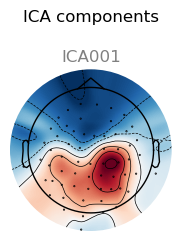

Subj01 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj02 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=6
Subj02 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=9
Subj02 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj03 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj03 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs

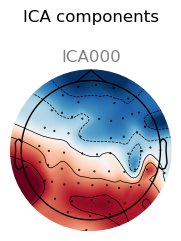

Subj03 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj03 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9
Subj04 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9


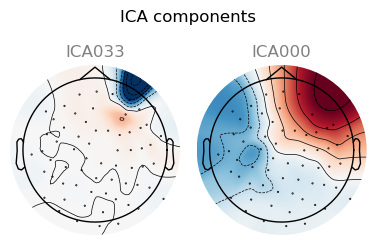

Subj04 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9


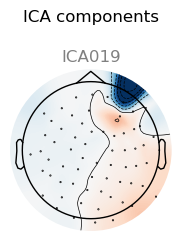

Subj05 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


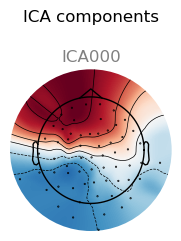

Subj05 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj05 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj05 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj06 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj06 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9


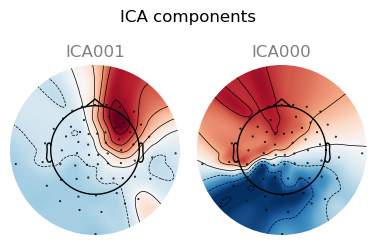

Subj06 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9


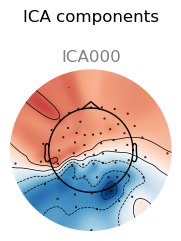

Subj07 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9


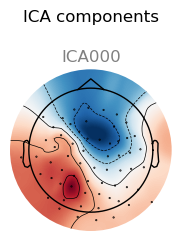

Subj07 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj08 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj08 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj08 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj08 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9


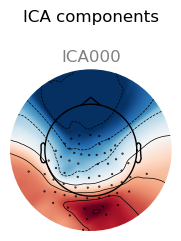

Subj09 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj09 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj10 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3


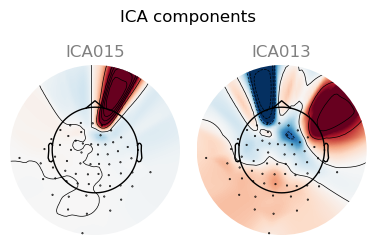

Subj10 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32


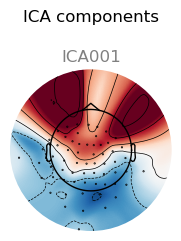

Subj10 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9
Subj10 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9


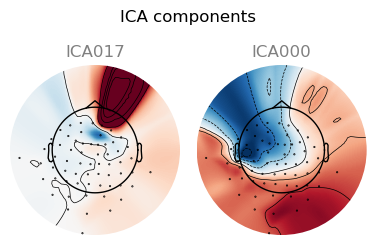

Subj11 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


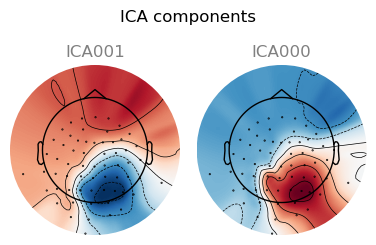

Subj11 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj11 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32


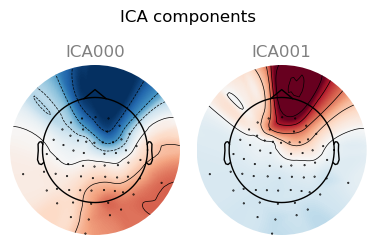

Subj12 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj12 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj12 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj13 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32


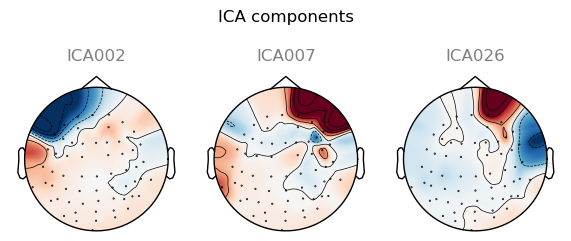

Subj13 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9


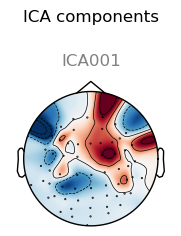

Subj13 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=32


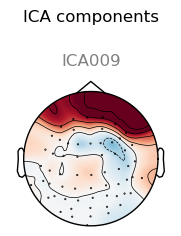

Subj14 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


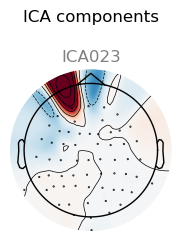

Subj14 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj14 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9


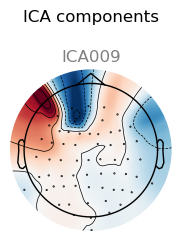

Subj14 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9


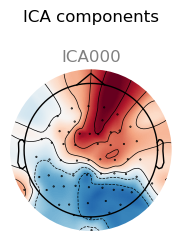

Subj15 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=9
Subj15 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.10 and n_interpolate=6
Subj15 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj16 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=32


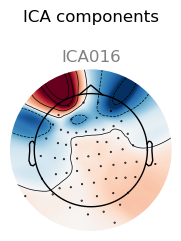

Subj16 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


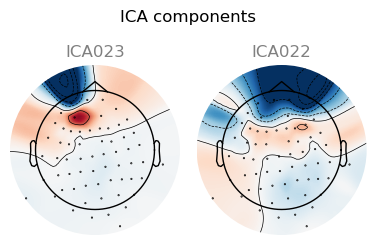

Subj16 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
Subj17 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj17 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9
Subj17 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9
Subj17 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9
Subj18 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32
Subj18 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=9
Subj18 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


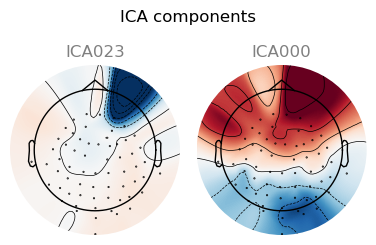

Subj18 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj19 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj19 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj19 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj20 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=6
Subj20 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs 

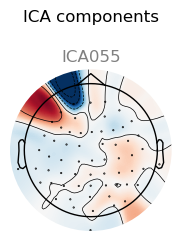

Subj20 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj20 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9
Subj21 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9
Subj21 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=9


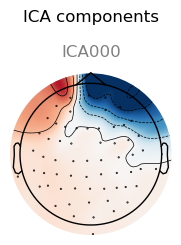

Subj21 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


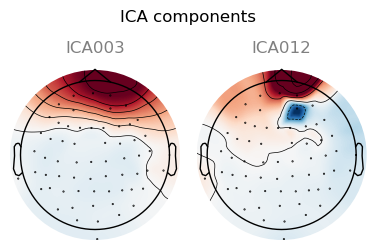

Subj21 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=32
Subj22 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj22 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj22 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Subj22 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.

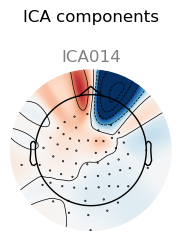

Subj25 Decoupled-Sham
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=9
Subj25 Non-Modulated
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=32
Subj25 tFUS-GC
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=9
Subj25 tFUS-GP
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=6
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


In [4]:
clean_df = pd.DataFrame(columns = ["subject", "condition", "data_epoch", "hit"])

threshold = 3.5 # slightly higher threshold since its the 2nd time ICA filtering will be run
random_seed = 0 # set the seed to get repeatable results :)

for subj in np.unique(df.subject):
    for cond in np.unique(df["condition"].loc[df.subject == subj]):
        print(subj, cond)
        
        for hit_cond in [True]:
            
            # Step 0: Concatenate Epochs and Filter
            x = mne.concatenate_epochs(df["data_epoch"].loc[
                (df.subject == subj) & 
                (df.condition == cond) & 
                (df.hit == hit_cond)].tolist())
            x.filter(1,40)
            
            # Step 1: Auto-reject bad epochs and clean channels
            if parse_mode == 'per_scan':
                ar = autoreject.AutoReject(n_interpolate=[3, 6, 9, 32], random_state=random_seed,
                                   n_jobs=1, verbose=True)
            elif parse_mode == 'per_letter':
                ar = autoreject.AutoReject(n_interpolate=[3, 6, 9, 32], random_state=random_seed,
                                   n_jobs=1, verbose=True, cv = 3)
            
            ar.fit(x)  # fit on a few epochs to save time
            epochs_clean, reject_log = ar.transform(x, return_log=True)

            # Step 2: Final ICA on cleaned epochs (and plot the found EOG bases)
            ica = mne.preprocessing.ICA(random_state=random_seed)
            ica.fit(epochs_clean)

            if "FP1" in epochs_clean.ch_names:
                eog_indices, eog_scores = ica.find_bads_eog(epochs_clean, ch_name = ["FP1", "FP2"], threshold = threshold)
            elif "Fp1" in epochs_clean.ch_names:
                eog_indices, eog_scores = ica.find_bads_eog(epochs_clean, ch_name = ["Fp1", "Fp2"], threshold = threshold)
            ica.exclude = eog_indices  
            if eog_indices:
                ica.plot_components(eog_indices)
            
            x = ica.apply(epochs_clean)

            # Step 4: Add the cleaned epochs to a new data frame
            for i in range(len(x)):
                clean_df.loc[len(clean_df)] = {"subject": subj, "condition": cond, "data_epoch": x[i], "hit": hit_cond}

                
# Save the preprocessed data
clean_df.to_pickle(output_file_name)

In [5]:
print("Total N: ", len(np.unique(df.subject)))
print("tFUS-GC N: ", len(np.unique(df["subject"].loc[df.condition == "tFUS"])))
print("tFUS-CP N: ", len(np.unique(df["subject"].loc[df.condition == "US-Control"])))
print("Non-Modulated N: ", len(np.unique(df["subject"].loc[df.condition == "Non-Modulated"])))
print("Decoupled-Sham N: ", len(np.unique(df["subject"].loc[df.condition == "Decoupled-Sham"])))

Total N:  25
tFUS-GC N:  0
tFUS-CP N:  0
Non-Modulated N:  24
Decoupled-Sham N:  19


In [6]:
import session_info
session_info.show()